In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

import yfinance as yf
from datetime import date, timedelta

ToDo:
* przerzucić tutaj cały proces przeliczeń i wykresów z wycen excelowych
* dodać obsługę weekendów, czyli, żeby najpierw zaciągał historyczne ceny do maksa, a potem tworzył wiersz current w oparciu o ostatnią dostępną datę z ceną
* 2 warianty:
    * zrobić dashboard, czyli wykresy w plotly i hostowanie jak w przypadku overview
    * zrzucać raporty do excela przez xlsx writera, wtedy wykresy raczej statyczne (chociaż może nie koniecznie)
* opcja 2 chyba byłaby bardziej dostosowana do cyklicznego raportowania, ale z drugiej strony, te raporty mają charakter inkrementalny, w sensie, co kwartał dane są takie same + kwartał, wiec bardziej to pasuje do monitorowania dashboardowego
* w dashboardzie możnaby zrobić taki fajny jednostronowy kompaktowy widok ze wszystkimi wykresikami i tabelkami upakowanymi w jedną stronę 16:9, żeby 

In [416]:
ticker_br = 'ATAL'
ticker_yf = '1AT.WA'
period = 'Y' # Y - Yearly, Q - Quarterly

In [441]:
ticker_br = 'AMBRA'
ticker_yf = 'AMB.WA'
period = 'Y' # Y - Yearly, Q - Quarterly

## Data scrapping and transformation

In [417]:
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

In [418]:
def table_cleaning(df):
    df = df.iloc[: , :-1]
    df.columns = df.columns.str.split('  ').str[0].str.replace('/', '', regex=True)

    for c in range(0, len(df.columns)):
        if 'k/k' in df.iloc[1,c]:
            df.iloc[:,c] = df.iloc[:,c].str.split('k/k').str[0]
        if 'r/r' in df.iloc[1,c]:
            df.iloc[:,c] = df.iloc[:,c].str.split('r/r').str[0]
        df.iloc[:,c] = df.iloc[:,c].astype(str).apply(lambda x: x.replace(' ', ''))
    
    df = df.T.reset_index()
    df = pd.concat([df, *[df.tail(1)]])
    df.iloc[-1, df.columns.get_loc('Data publikacji')] = date.today() - timedelta(days = 1)
    df.iloc[-1, df.columns.get_loc('index')] = 'Current'
    df['Data publikacji'] = pd.to_datetime(df['Data publikacji'])
    
    for c in df.columns[2:]:
        df[c] = df[c].astype(float)

    return df

In [419]:
url_rzis = 'https://www.biznesradar.pl/raporty-finansowe-rachunek-zyskow-i-strat/'+ticker_br+','+period
url_bilans = 'https://www.biznesradar.pl/raporty-finansowe-bilans/'+ticker_br+','+period
url_pp = 'https://www.biznesradar.pl/raporty-finansowe-przeplywy-pieniezne/'+ticker_br+','+period
url_c = 'https://www.biznesradar.pl/wskazniki-wartosci-rynkowej/'+ticker_br+''

In [420]:
df_r_raw = pd.read_html(url_rzis, match='Data publikacji', index_col=0)[0]
df_b_raw = pd.read_html(url_bilans, match='Data publikacji', index_col=0)[0]
df_p_raw = pd.read_html(url_pp, match='Data publikacji', index_col=0)[0]

In [421]:
df_r = table_cleaning(df_r_raw)
df_b = table_cleaning(df_b_raw)
df_p = table_cleaning(df_p_raw)

In [422]:
prices = yf.download(ticker_yf, df_r['Data publikacji'].min(), date.today())['Close'].reset_index()
prices.columns = ['Data publikacji', 'Cena']

[*********************100%%**********************]  1 of 1 completed


In [423]:
df = df_r.merge(
    df_b, how='outer', left_on='Data publikacji', right_on='Data publikacji').merge(
        df_p, how='outer', left_on='Data publikacji', right_on='Data publikacji')
df = df.drop(columns=['index_y', 'index_x'])

In [424]:
df_c_raw = pd.read_html(url_c, match='Kurs', index_col=0)[0]

df_c = df_c_raw.iloc[: , :-1]
df_c.columns = df_c.columns.str.split('  ').str[0].str.replace('/', '', regex=True)
df_c = df_c.T
df_c = df_c['Liczba akcji'].reset_index()
df_c['Liczba akcji'] = df_c['Liczba akcji'].str.replace(' ', '', regex=True).astype(float)

if period == 'Y':
    df_c['index'] = df_c['index'].str[:4]
    df_c = df_c.drop_duplicates()

In [425]:
df = df.merge(df_c, how='left', left_on='index', right_on='index')
df['Liczba akcji'] = df['Liczba akcji'].fillna(df['Liczba akcji'].mean())

In [426]:
df = df.merge(prices, how='left', left_on='Data publikacji', right_on='Data publikacji')

In [427]:
df.head(2)

,Data publikacji,Przychody ze sprzedaży,Techniczny koszt wytworzenia produkcji sprzedanej,Koszty sprzedaży,Koszty ogólnego zarządu,Zysk ze sprzedaży,Pozostałe przychody operacyjne,Pozostałe koszty operacyjne,Zysk operacyjny (EBIT),Przychody finansowe,...,CAPEX (niematerialne i rzeczowe),Przepływy pieniężne z działalności finansowej,Emisja akcji,Dywidenda,Skup akcji,Płatności z tytułu umów leasingu,Przepływy pieniężne razem,Free Cash Flow,Liczba akcji,Cena
0,2012-03-20,161440.0,115591.0,3170.0,3858.0,38821.0,1137.0,4892.0,35066.0,771.0,...,624.0,10958.0,0.0,0.0,NaN,NaN,138.0,-11509.0,161073000.0,NaN
1,2013-03-20,173874.0,126610.0,6240.0,4556.0,36468.0,3404.0,1438.0,38434.0,3815.0,...,672.0,28575.0,50.0,205.0,NaN,NaN,-25359.0,-54051.0,161073000.0,NaN


In [428]:
df.columns

Index(['Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Koszty finansowe',
       'Pozostałe przychody (koszty)', 'Zysk z działalności gospodarczej',
       'Wynik zdarzeń nadzwyczajnych', 'Zysk przed opodatkowaniem',
       'Zysk (strata) netto z działalności zaniechanej', 'Zysk netto',
       'Zysk netto akcjonariuszy jednostki dominującej', 'EBITDA',
       'Aktywa trwałe', 'Wartości niematerialne i prawne', 'Wartość firmy',
       'Rzeczowe składniki majątku trwałego',
       'Aktywa z tytułu prawa do użytkowania', 'Należności długoterminowe',
       'Inwestycje długoterminowe', 'Pozostałe aktywa trwałe',
       'Aktywa obrotowe', 'Zapasy', 'Należności krótkoterminowe',
       'Inwestycje krótkoterminowe',
       'Środki pieni

## Statistics

In [429]:
# Statystyki
stats = pd.DataFrame()
stats['index'] = df['index']
stats['Cena'] = df['Cena']
# Rynkowe
stats['Przychód na akcję'] = (df['Przychody ze sprzedaży'] * 1000) / df['Liczba akcji']
stats['Zysk netto na akcję (EPS)'] = (df['Zysk netto'] * 1000) / df['Liczba akcji']
stats['Wartość księgowa na akcję'] = (df['Kapitał własny akcjonariuszy jednostki dominującej'] * 1000) / df['Liczba akcji']
stats['Zobowiązania na akcję'] = ((df['Zobowiązania długoterminowe'] + df['Zobowiązania krótkoterminowe']) * 1000) / df['Liczba akcji']
stats['C/Z'] = stats['Cena'] / stats['Zysk netto na akcję (EPS)']
stats['C/WK'] = stats['Cena'] / stats['Wartość księgowa na akcję']
# Dywidend - dodać

# Przepływów
stats['Przepływy finansowe na akcję'] = (df['Przepływy pieniężne z działalności finansowej'] * 1000) / df['Liczba akcji']
stats['Przepływy inwestycyjne na akcję'] = (df['Przepływy pieniężne z działalności inwestycyjnej'] * 1000) / df['Liczba akcji']
stats['Przepływy operacyjne na akcję'] = (df['Przepływy pieniężne z działalności operacyjnej'] * 1000) / df['Liczba akcji']
# Rentowności
stats['ROE (zwrot z kapitału)'] = df['Zysk netto'] / df['Kapitał własny akcjonariuszy jednostki dominującej']
stats['ROA (zwrot z całości aktywów)'] = df['Zysk netto'] / df['Aktywa razem']
stats['ROS (zwrot ze sprzedaży)'] = df['Zysk netto'] / df['Przychody ze sprzedaży']
# Zadłużenia
stats['Debt Ratio (zadłużenie ogólne)'] = (df['Zobowiązania długoterminowe'] + df['Zobowiązania krótkoterminowe']) / df['Aktywa razem']
# Płynności
stats['Current Ratio (płynność bieżąca)'] = df['Aktywa obrotowe'] / df['Zobowiązania krótkoterminowe']
stats['Quick Ratio (płynność szybka)'] = (df['Aktywa obrotowe'] - df['Zapasy']) / df['Zobowiązania krótkoterminowe']
stats['Cash Ratio (płynność gotówkowa)'] = df['Środki pieniężne i inne aktywa pieniężne'] / df['Zobowiązania krótkoterminowe']

In [430]:
stats

,index,Cena,Przychód na akcję,Zysk netto na akcję (EPS),Wartość księgowa na akcję,Zobowiązania na akcję,C/Z,C/WK,Przepływy finansowe na akcję,Przepływy inwestycyjne na akcję,Przepływy operacyjne na akcję,ROE (zwrot z kapitału),ROA (zwrot z całości aktywów),ROS (zwrot ze sprzedaży),Debt Ratio (zadłużenie ogólne),Current Ratio (płynność bieżąca),Quick Ratio (płynność szybka),Cash Ratio (płynność gotówkowa)
0,2011,NaN,1.002278,0.142172,1.470818,1.461275,NaN,NaN,0.068031,0.000404,-0.067578,0.096662,0.048488,0.141848,0.498373,1.926621,0.256314,0.187977
1,2012,NaN,1.079473,0.185897,1.656081,1.898791,NaN,NaN,0.177404,-0.003446,-0.331396,0.112251,0.052289,0.172211,0.534090,2.178064,0.074393,0.029377
2,2013,NaN,1.454620,0.213667,1.861827,2.878720,NaN,NaN,0.042819,0.005215,0.393840,0.114762,0.045224,0.146889,0.609296,1.931280,0.280573,0.244817
3,2014,NaN,3.580712,0.847479,2.709343,2.219571,NaN,NaN,-0.040888,0.018619,0.003955,0.312799,0.173480,0.236679,0.454349,3.329269,0.480273,0.389338
4,2015,NaN,5.859468,1.223311,16.085426,15.455431,NaN,NaN,5.384737,0.025055,-3.968889,0.076051,0.039141,0.208775,0.494508,2.346878,0.355980,0.145760
5,2016,32.900002,13.091698,2.405500,17.783958,21.644464,13.676990,1.849982,3.498343,0.002996,-2.007976,0.135262,0.061529,0.183742,0.553636,2.608742,0.414049,0.171716
6,2017,42.500000,22.363521,4.642356,20.527470,25.867960,9.154834,2.070396,-3.115620,0.023996,5.116234,0.226153,0.100421,0.207586,0.559562,2.369256,0.425110,0.196962
7,2018,37.500000,27.251288,5.337442,22.171526,26.210208,7.025837,1.691359,-2.924219,0.036550,0.977538,0.240734,0.110384,0.195860,0.542055,2.769927,0.382833,0.046927
8,2019,27.500000,18.601944,2.987322,20.375460,41.860347,9.205570,1.349663,2.390777,0.277905,-3.728024,0.146614,0.048000,0.160592,0.672609,3.194964,0.249036,0.020174
9,2020,41.500000,30.152803,4.325370,24.697808,47.438086,9.594556,1.680311,0.888915,0.029059,1.434084,0.175132,0.059962,0.143448,0.657627,2.283271,0.244419,0.152447


In [431]:
df.to_pickle('data/df-'+ticker_br+'-'+period+'.pkl')
stats.to_pickle('data/stats-'+ticker_br+'-'+period+'.pkl')

## Plots

In [442]:
def addlabels(x,y,c):
    for i in range(len(x)):
        plt.text(i,y[i]+y[i]*0.05,"{:.2f}".format(y[i]), color=c, ha='center')

In [443]:
df = pd.read_pickle('data/df-'+ticker_br+'-'+period+'.pkl')
stats = pd.read_pickle('data/stats-'+ticker_br+'-'+period+'.pkl')

In [444]:
stats.tail()

,index,Cena,Przychód na akcję,Zysk netto na akcję (EPS),Wartość księgowa na akcję,Zobowiązania na akcję,C/Z,C/WK,Przepływy finansowe na akcję,Przepływy inwestycyjne na akcję,Przepływy operacyjne na akcję,ROE (zwrot z kapitału),ROA (zwrot z całości aktywów),ROS (zwrot ze sprzedaży),Debt Ratio (zadłużenie ogólne),Current Ratio (płynność bieżąca),Quick Ratio (płynność szybka),Cash Ratio (płynność gotówkowa)
16,2020,24.000000,26.706014,2.397384,12.939128,7.787233,10.010913,1.854839,-3.378712,-0.637848,4.257766,0.185282,0.104420,0.089769,0.339179,2.021531,1.081966,0.188516
17,2021,20.799999,30.771570,2.630973,14.168725,11.120084,7.905820,1.468022,-0.391008,-1.093482,1.396338,0.185689,0.094751,0.085500,0.400475,1.734097,0.784436,0.118719
18,2022,29.400000,34.745244,3.010635,15.500397,12.315682,9.765382,1.896726,-1.819758,-1.011757,2.736223,0.194230,0.098296,0.086649,0.402100,1.802205,0.758444,0.099374
19,O4K,31.500000,35.535076,2.845559,15.937703,18.339847,11.069880,1.976445,-1.422204,-1.564270,2.958426,0.178543,0.076237,0.080077,0.491356,1.529523,0.907096,0.067762
20,Current,NaN,35.535076,2.845559,15.937703,18.339847,NaN,NaN,-1.422204,-1.564270,2.958426,0.178543,0.076237,0.080077,0.491356,1.529523,0.907096,0.067762


In [445]:
d = stats.copy()
d['Średnie ROE'] = d['ROE (zwrot z kapitału)'].mean()

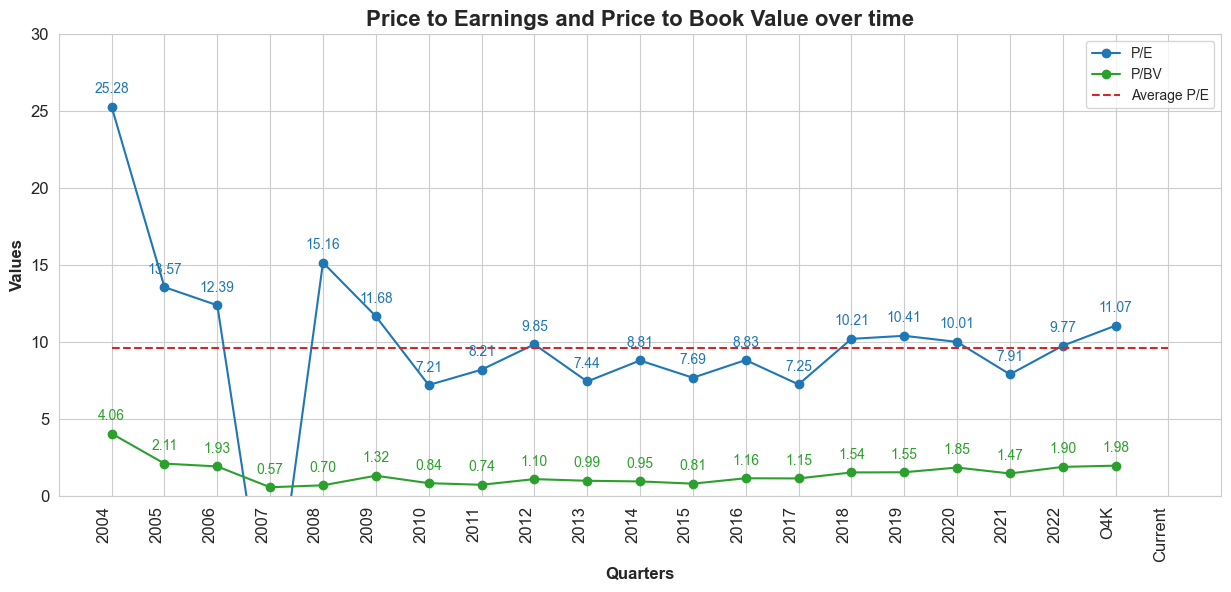

In [453]:
# P/E and P/BV plots
fig, ax = plt.subplots(figsize=(15, 6))
font = 12

plt.plot(d['index'], d['C/Z'], marker='o', label='P/E', color='tab:blue')
plt.plot(d['index'], d['C/WK'], marker='o', label='P/BV', color='tab:green')


# zamiast tych absolutnych wartości to trzeba tu dać średnią
# plt.plot(d['index'], np.full(shape=len(d), fill_value=15), linestyle='--', label='Theoretically overpriced', color='tab:red')
# plt.plot(d['index'], np.full(shape=len(d), fill_value=10), linestyle='--', label='Theoretically equilibrium', color='tab:grey')
plt.plot(d['index'], np.full(shape=len(d), fill_value=d['C/Z'].mean()), linestyle='--', label='Average P/E', color='tab:red')

for x,y in zip(d['index'],d['C/Z']):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='tab:blue',
                 ha='center')

for x,y in zip(d['index'],d['C/WK']):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='tab:green',
                 ha='center')

ax.set_ylim(0, 30)
ax.set_title('Price to Earnings and Price to Book Value over time', fontsize=16, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Quarters', fontsize=font, fontdict=dict(weight='bold'))
ax.set_ylabel('Values', fontsize=font, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=font)
plt.tick_params(axis='x', which='major', labelsize=font)
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.savefig('plots/'+ticker_br+'-'+period+'-pe-pbv.png', dpi='figure',bbox_inches='tight')
# plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


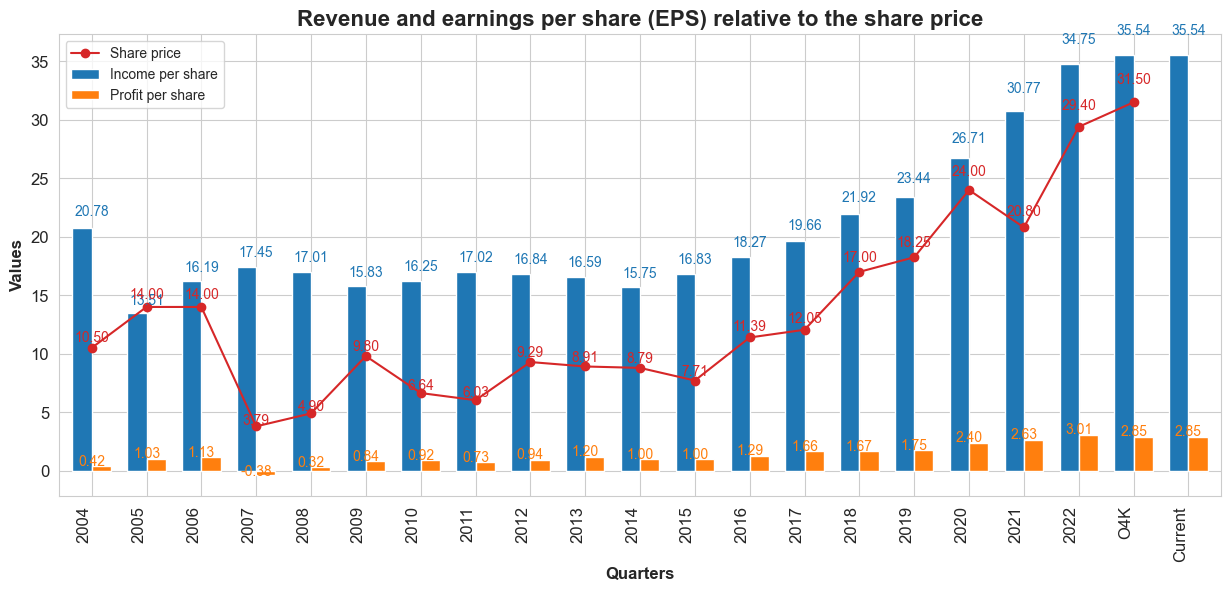

In [447]:
# Income, Profit, Price
Y = {
    'y1': [d['Przychód na akcję'], 'tab:blue', 'Income per share'],
    'y2': [d['Zysk netto na akcję (EPS)'], 'tab:orange', 'Profit per share'],
    'y3': [d['Cena'], 'tab:red', 'Share price'],
}
font = 12
width = .7

d_temp = pd.concat([Y['y1'][0], Y['y2'][0]], axis=1)
d_temp.columns = [Y['y1'][2], Y['y2'][2]]
d_temp.plot(kind='bar', color=[Y['y1'][1], Y['y2'][1]], width = width, figsize=(15, 6))
Y['y3'][0].plot(kind='line', marker='o', label=Y['y3'][2], color=Y['y3'][1])

ax = plt.gca()
ax.set_xticklabels(d['index'].tolist())

addlabels(d['index'].tolist(), Y['y1'][0], Y['y1'][1])
addlabels(d['index'].tolist(), Y['y2'][0], Y['y2'][1])
addlabels(d['index'].tolist(), Y['y3'][0], Y['y3'][1])

ax.set_title("Revenue and earnings per share (EPS) relative to the share price", fontsize=16, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Quarters', fontsize=font, fontdict=dict(weight='bold'))
ax.set_ylabel('Values', fontsize=font, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=font)
plt.tick_params(axis='x', which='major', labelsize=font)
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.savefig('plots/'+ticker_br+'-'+period+'-income-profit-price.png', dpi='figure',bbox_inches='tight')
# plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


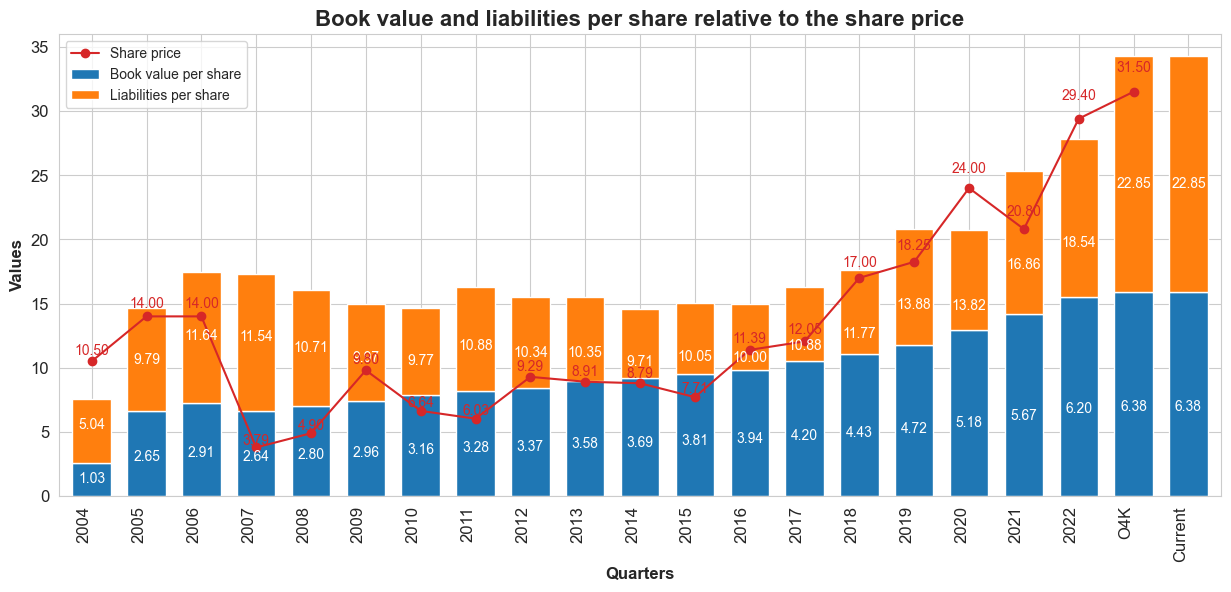

In [448]:
# Book Value, Liability, Price
Y = {
    'y1': [d['Wartość księgowa na akcję'], 'tab:blue', 'Book value per share'],
    'y2': [d['Zobowiązania na akcję'], 'tab:orange', 'Liabilities per share'],
    'y3': [d['Cena'], 'tab:red', 'Share price'],
}
font = 12
width = .7

d_temp = pd.concat([Y['y1'][0], Y['y2'][0]], axis=1)
d_temp.columns = [Y['y1'][2], Y['y2'][2]]
d_temp.plot(kind='bar', color=[Y['y1'][1], Y['y2'][1]], width = width, stacked=True, figsize=(15, 6))
Y['y3'][0].plot(kind='line', marker='o', label=Y['y3'][2], color=Y['y3'][1])

ax = plt.gca()
ax.set_xticklabels(d['index'].tolist())

addlabels(d['index'].tolist(), Y['y1'][0]/2.5, 'white')
addlabels(d['index'].tolist(), (Y['y1'][0] + Y['y2'][0])/1.5, 'white')
addlabels(d['index'].tolist(), Y['y3'][0], Y['y3'][1])

ax.set_title("Book value and liabilities per share relative to the share price", fontsize=16, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Quarters', fontsize=font, fontdict=dict(weight='bold'))
ax.set_ylabel('Values', fontsize=font, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=font)
plt.tick_params(axis='x', which='major', labelsize=font)
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.savefig('plots/'+ticker_br+'-'+period+'-book-liab-price.png', dpi='figure',bbox_inches='tight')
# plt.show()

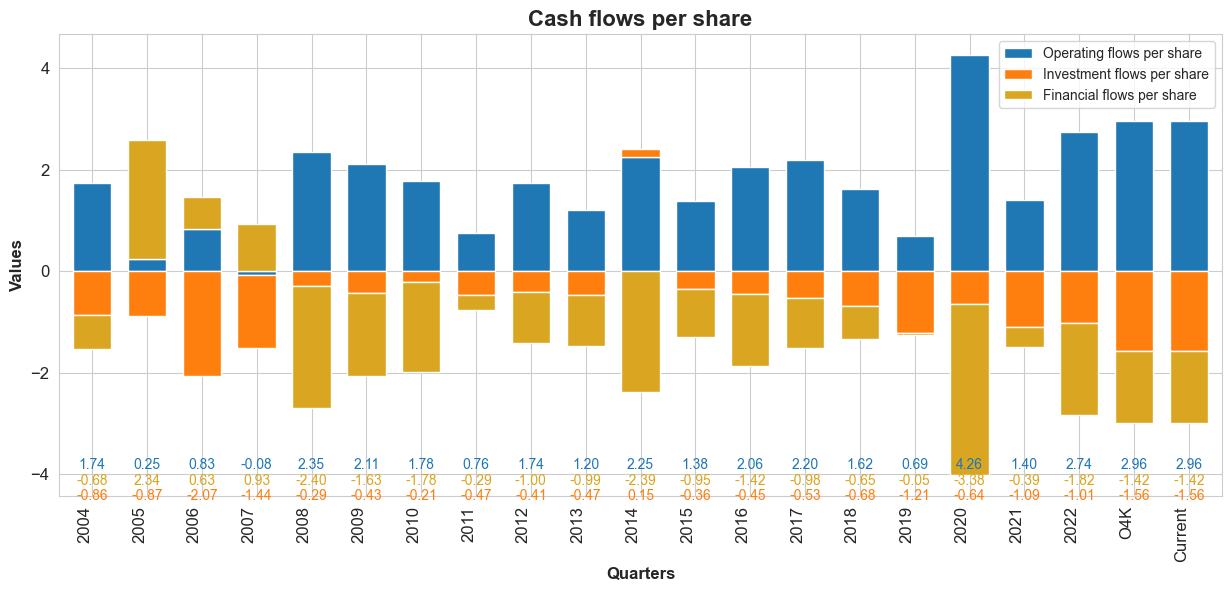

In [449]:
def addlabels2(x,y,c,z):
    for i in range(len(x)):
        plt.text(i, z, "{:.2f}".format(y[i]), color=c, ha='center')

# Book Value, Liability, Price
Y = {
    'y1': [d['Przepływy operacyjne na akcję'], 'tab:blue', 'Operating flows per share'],
    'y2': [d['Przepływy inwestycyjne na akcję'], 'tab:orange', 'Investment flows per share'],
    'y3': [d['Przepływy finansowe na akcję'], 'goldenrod', 'Financial flows per share'],
}
font = 12
width = .7

d_temp = pd.concat([Y['y1'][0], Y['y2'][0], Y['y3'][0]], axis=1)
d_temp.columns = [Y['y1'][2], Y['y2'][2], Y['y3'][2]]
d_temp.plot(kind='bar', color=[Y['y1'][1], Y['y2'][1], Y['y3'][1]], width = width, stacked=True, figsize=(15, 6))
# Y['y3'][0].plot(kind='line', marker='o', label=Y['y3'][2], color=Y['y3'][1])

ax = plt.gca()
ax.set_xticklabels(d['index'].tolist())

addlabels2(d['index'].tolist(), Y['y1'][0], Y['y1'][1], -3.9)
addlabels2(d['index'].tolist(), Y['y2'][0], Y['y2'][1], -4.5)
addlabels2(d['index'].tolist(), Y['y3'][0], Y['y3'][1], -4.2)

ax.set_title("Cash flows per share", fontsize=16, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Quarters', fontsize=font, fontdict=dict(weight='bold'))
ax.set_ylabel('Values', fontsize=font, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=font)
plt.tick_params(axis='x', which='major', labelsize=font)
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.savefig('plots/'+ticker_br+'-'+period+'-cash-flows.png', dpi='figure',bbox_inches='tight')
# plt.show()

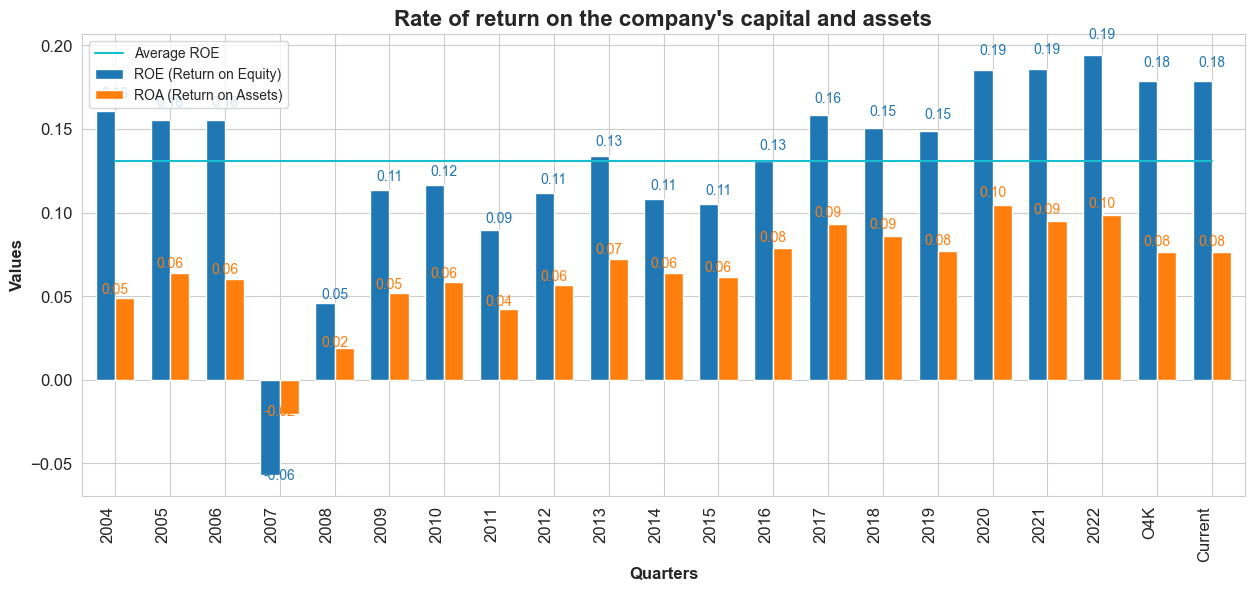

In [450]:
# Income, Profit, Price
Y = {
    'y1': [d['ROE (zwrot z kapitału)'], 'tab:blue', 'ROE (Return on Equity)'],
    'y2': [d['ROA (zwrot z całości aktywów)'], 'tab:orange', 'ROA (Return on Assets)'],
    'y3': [d['Średnie ROE'], 'tab:cyan', 'Average ROE'],
}
font = 12
width = .7

d_temp = pd.concat([Y['y1'][0], Y['y2'][0]], axis=1)
d_temp.columns = [Y['y1'][2], Y['y2'][2]]
d_temp.plot(kind='bar', color=[Y['y1'][1], Y['y2'][1]], width = width, figsize=(15, 6))
Y['y3'][0].plot(kind='line', label=Y['y3'][2], color=Y['y3'][1])


# plt.plot(d['index'], np.full(shape=len(d), fill_value=15), linestyle='--', label='Theoretically overpriced', color='tab:red')

ax = plt.gca()
ax.set_xticklabels(d['index'].tolist())

addlabels(d['index'].tolist(), Y['y1'][0], Y['y1'][1])
addlabels(d['index'].tolist(), Y['y2'][0], Y['y2'][1])

ax.set_title("Rate of return on the company's capital and assets", fontsize=16, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Quarters', fontsize=font, fontdict=dict(weight='bold'))
ax.set_ylabel('Values', fontsize=font, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=font)
plt.tick_params(axis='x', which='major', labelsize=font)
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.savefig('plots/'+ticker_br+'-'+period+'-roe-roa-avg.png', dpi='figure',bbox_inches='tight')
# plt.show()